# Artificial Intelligence and Machine Learning

## Unit II


## Decision Trees and Random Forest

In [107]:
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
img[alt=regression] { width: "50%"; }
</style>
""")

## My own latex definitions
$\require{color}$


$$\def\mbf#1{\mathbf{#1}}$$
$$\def\bmf#1{\boldsymbol{#1}}$$
$$\def\bx{\mbf{x}}$$
$$\def\bv{\mbf{v}}$$
$$\def\bz{\mbf{z}}$$
$$\def\bmu{\bmf{\mu}}$$
$$\def\bsigma{\bmf{\Sigma}}$$
$$\def\Rd#1{\in \mathbb{R}^{#1}}$$

In [108]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# plt.style.use('seaborn-whitegrid')

font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)


# Aux functions

def plot_grid(Xs, Ys, axs=None):
    ''' Aux function to plot a grid'''
    t = np.arange(Xs.size) # define progression of int for indexing colormap
    if axs:
        axs.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        axs.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        axs.axis('scaled') # axis scaled
    else:
        plt.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        plt.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        plt.axis('scaled') # axis scaled
        
def linear_map(A, Xs, Ys):
    '''Map src points with A'''
    # [NxN,NxN] -> NxNx2 # add 3-rd axis, like adding another layer
    src = np.stack((Xs,Ys), axis=Xs.ndim)
    # flatten first two dimension
    # (NN)x2
    src_r = src.reshape(-1,src.shape[-1]) #ask reshape to keep last dimension and adjust the rest
    # 2x2 @ 2x(NN)
    dst = A @ src_r.T # 2xNN
    #(NN)x2 and then reshape as NxNx2
    dst = (dst.T).reshape(src.shape)
    # Access X and Y
    return dst[...,0], dst[...,1]


def plot_points(ax, Xs, Ys, col='red', unit=None, linestyle='solid'):
    '''Plots points'''
    ax.set_aspect('equal')
    ax.grid(True, which='both')
    ax.axhline(y=0, color='gray', linestyle="--")
    ax.axvline(x=0, color='gray',  linestyle="--")
    ax.plot(Xs, Ys, color=col)
    if unit is None:
        plotVectors(ax, [[0,1],[1,0]], ['gray']*2, alpha=1, linestyle=linestyle)
    else:
        plotVectors(ax, unit, [col]*2, alpha=1, linestyle=linestyle)

def plotVectors(ax, vecs, cols, alpha=1, linestyle='solid'):
    '''Plot set of vectors.'''
    for i in range(len(vecs)):
        x = np.concatenate([[0,0], vecs[i]])
        ax.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                   alpha=alpha, linestyle=linestyle, linewidth=2)

# Recap previous lecture
- Supervised Learning with $k$-NN
- k-NN strenghts and limitations
- A bit of theory of learning Empirical Risk Minimization
- Usage of the validation set

# Today's lecture
## Another "non-parametric" model
### Decision Trees


# This lecture material is taken from
- Information Theory part  - (Entropy etc) is taken from __Chapter 1 - Bishop__.
- Decision Trees are very briefly covered in __Bishop at page 663__.
- [Cimi Book - Chapter 01](http://ciml.info/dl/v0_99/ciml-v0_99-ch01.pdf)
- [CSC411: Introduction to Machine Learning](https://www.cs.toronto.edu/~urtasun/courses/CSC411_Fall16/06_trees_handout.pdf)
- [CSC411: Introduction to Machine Learning - Tutorial](https://www.cs.toronto.edu/~urtasun/courses/CSC411_Fall16/tutorial3.pdf)
- [Cornell ML course](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote17.html)
- [Cornell ML course Bagging](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote18.html)

# From $k$-NN to Decision Trees

#### Non-parametric models

# Recall $k$-NN 

- Denote the set of the $k$ nearest neighbors of $\mathbf{x}$ as $S_{\mathbf{x}}$. Formally $S_{\mathrm{x}}$ is defined as $S_{\mathrm{x}} \subseteq D$ s.t. $\left|S_{\mathrm{x}}\right|=k$ and $\forall\left(\mathbf{x}^{\prime}, y^{\prime}\right) \in D \backslash S_{\mathrm{x} \prime}$
$$
\operatorname{dist}\left(\mathbf{x}, \mathbf{x}^{\prime}\right) \geq \max _{\left(\mathbf{x}^{\prime \prime}, y^{\prime \prime}\right) \in S_{\mathbf{x}}} \operatorname{dist}\left(\mathbf{x}, \mathbf{x}^{\prime \prime}\right)
$$



- (i.e. every point in $D$ but not in $S_{\mathrm{x}}$ is at least as far away from $\mathbf{x}$ as the furthest point in $S_{\mathbf{x}}$ ). 

- We can then define the classifier $h()$ as a function returning the most common label in $S_{\mathrm{x}}$ :
$$
h(\mathbf{x})=\operatorname{mode}\left(\left\{y^{\prime \prime}:\left(\mathbf{x}^{\prime \prime}, y^{\prime \prime}\right) \in S_{\mathbf{x}}\right\}\right)
$$

# Ambiguous cases based on the distance and neighbours


<center>
<img width="40%" src="figs/nn.png" />
<center/>

# Over or Under Fitting
<center>
<img width="60%" src="figs/over_under_fit.png" />
<center/>

# $k$-NN has irregular and non-linear decision boundaries

# What is the the training error of $k$-NN? 🤔

- In $k$-NN there there is no explit cost/loss, how can we measure the training error? 


- What we **can do is to <ins>classify the train with respect to the train</ins>, given a fixed inductive bias (configuration of $k$-NN used).**


- So classify the training points as if they were validation points, given a fixed $k$-NN configuration.

# What happens when you classify the training set with $k=1$?

## Ideas?

## let's see with an example...

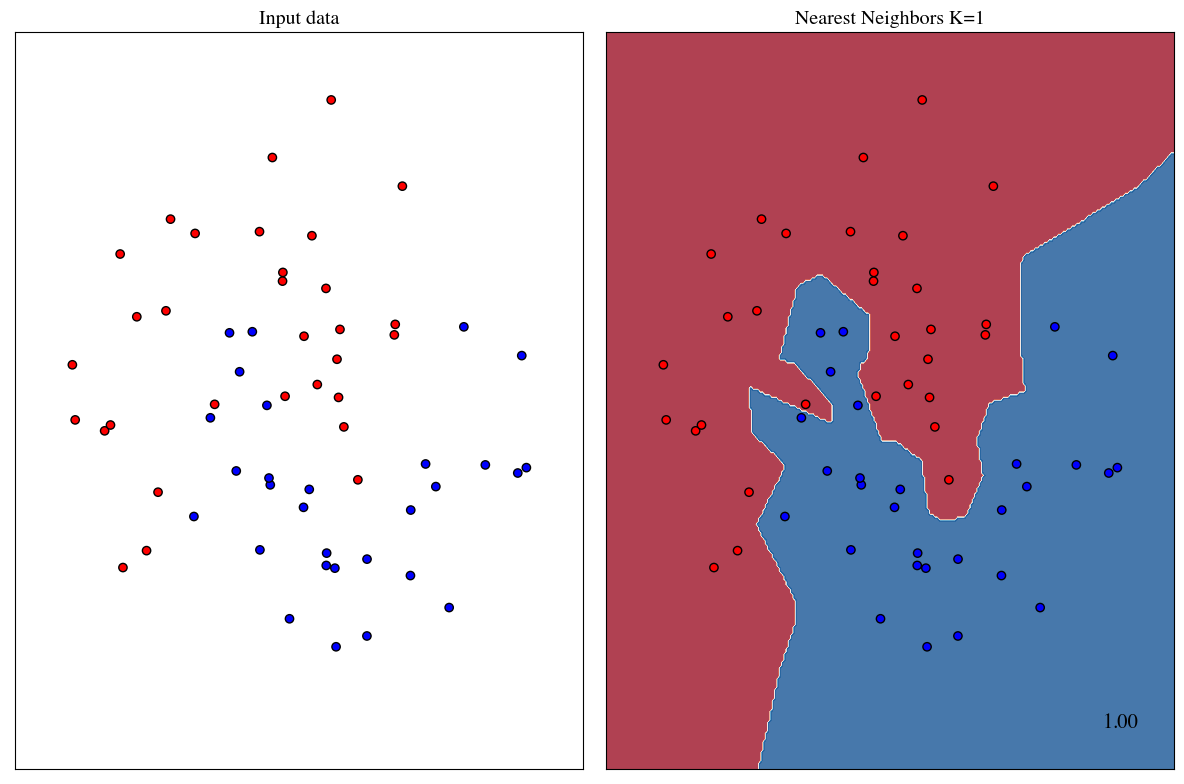

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier


h = 0.02  # step size in the mesh
K = 1  # Neighbors

names = [
    "Nearest Neighbors",
]

classifiers = [
    KNeighborsClassifier(K),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
]

figure = plt.figure(figsize=(12,8))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
               cmap=cm_bright, edgecolors="k")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_train, y_train)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:,1],
            c=y_train, cmap=cm_bright, edgecolors="k"
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name+f' K={K}')
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

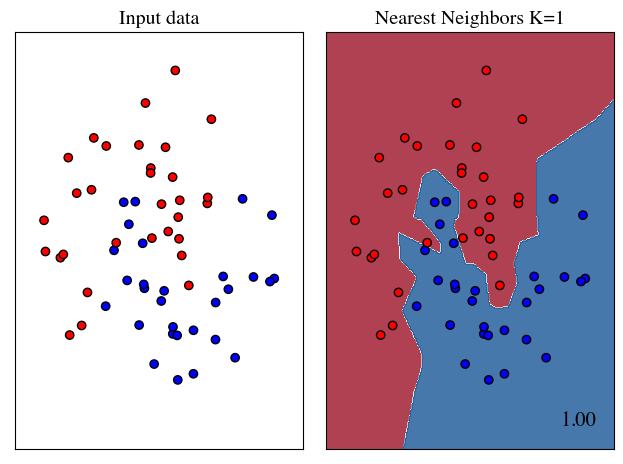

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier


h = 0.02  # step size in the mesh
K = 1  # Neighbors

names = [
    "Nearest Neighbors",
]

classifiers = [
    KNeighborsClassifier(K),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
]

figure = plt.figure()
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
               cmap=cm_bright, edgecolors="k")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_train, y_train)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:,1],
            c=y_train, cmap=cm_bright, edgecolors="k"
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name+f' K={K}')
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

# When $k=1$ we perfectly classify the training set! 100% accuracy!

It is easy to show that this follow by definition **(each point is neighbour to itself).**

but will this hold for $K \gt 1$?

# We record the training accuracy in function of increasing $k$

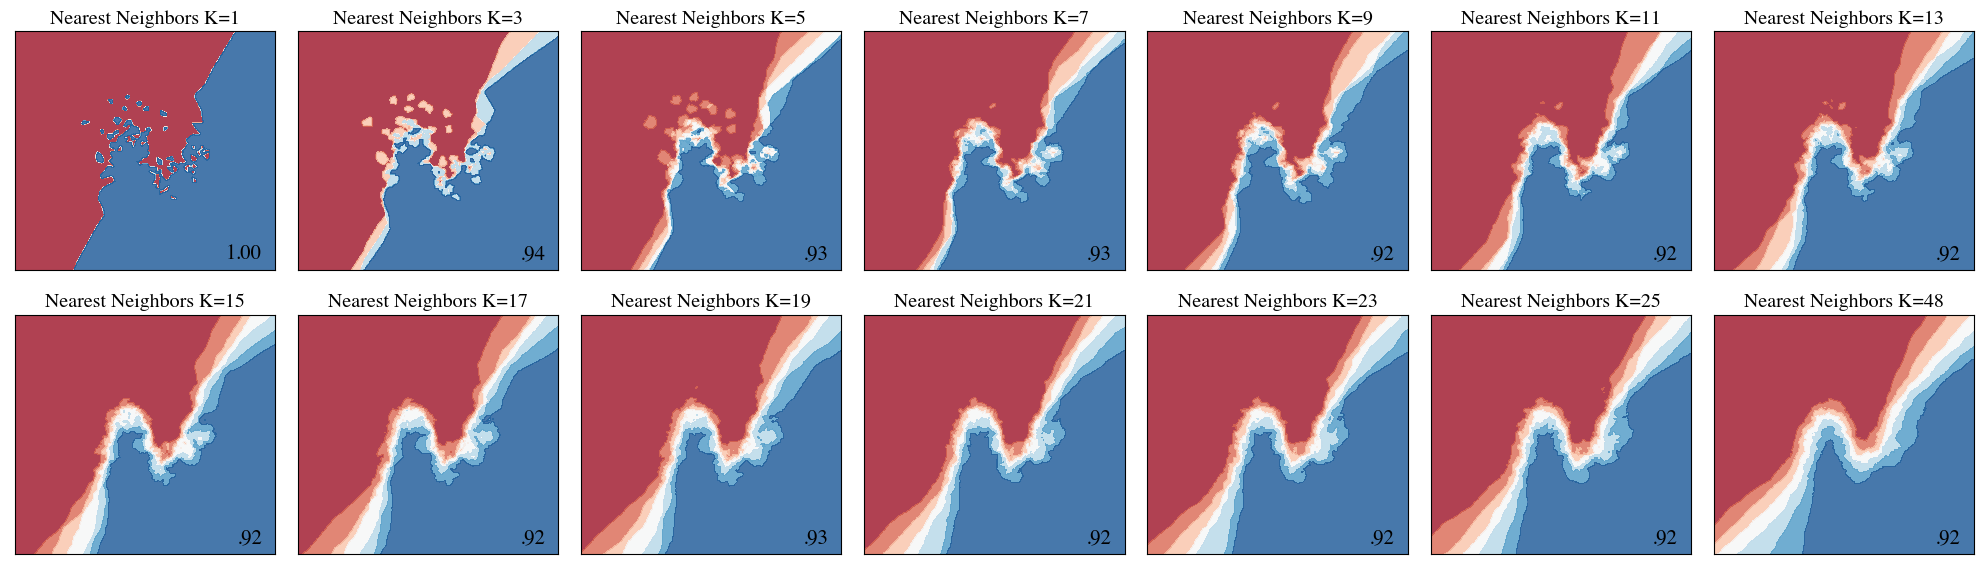

In [111]:
###################
h = 0.02  # step size in the mesh
plot_train_points = False
idx_plot = 1  # plot points of attempt idx_plot
#################

names = [
    "Nearest Neighbors",
]

Krange = list(range(1, 27, 2)) + [48]

accuracies = np.zeros_like(Krange, dtype=np.float32)
accuracies_valid = np.zeros_like(Krange, dtype=np.float32)

datasets = [
    make_moons(n_samples=2000, noise=0.3, random_state=0),
]

figure = plt.figure(figsize=(20, 20))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    ######### Watch out here ################
    X = StandardScaler().fit_transform(X)  # in theory this is an error!
    # you want to estimate the scaling of data on the training set and then apply to valid and test
    ##########################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    # validation from training (overwrite X_train)
    X_train_entire, y_train_entire = np.copy(X_train), np.copy(y_train)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42)

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(Krange) + 1, 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    # ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
    #           cmap=cm_bright, edgecolors="k")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    #i += 1
    # iterate over classifiers
    mid = len(Krange)//2
    for K in Krange:
        clf = KNeighborsClassifier(K)
        ax = plt.subplot(mid, mid, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_train, y_train)
        score_test = clf.score(X_valid, y_valid)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot the training points
        if i == idx_plot and plot_train_points:
            ax.scatter(
                X_train[:, 0], X_train[:, 1],
                c=y_train, cmap=cm_bright, edgecolors="k"
            )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(names[0]+f' K={K}')
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        # recording the accuracies
        accuracies[i-1] = score
        accuracies_valid[i-1] = score_test
        # print(accuracies,i,score)
        i += 1

plt.tight_layout()
plt.show()

# Let's see the training error in function of $k$

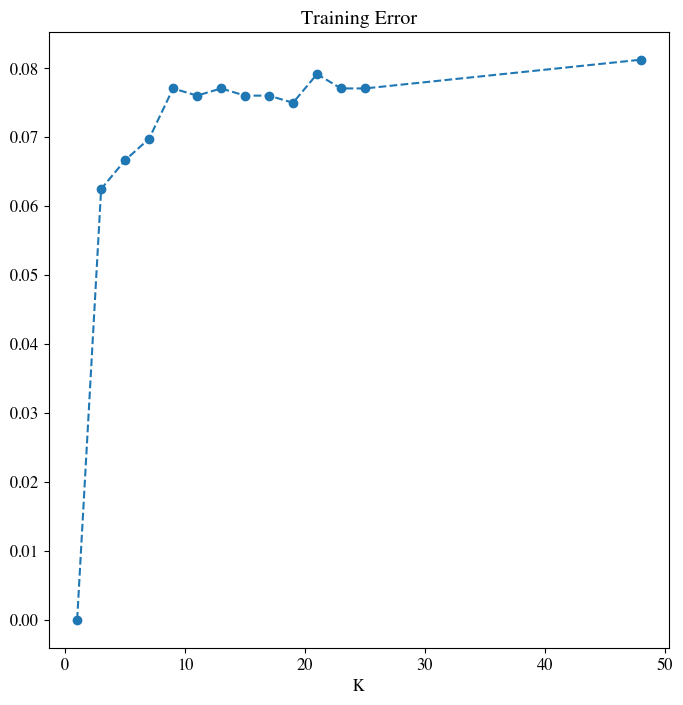

In [112]:
plt.figure(figsize=(8, 8))
_ = plt.plot(Krange, 1 - accuracies, 'o--')
_ = plt.title('Training Error')
_ = plt.xlabel('K')

# Let's see how it generalize

- We are going to select the best $k^{\prime}$ from validation

- Then re-train with the best $k^{\prime}$ from validation

- Now everything is fixed and locked and we can test

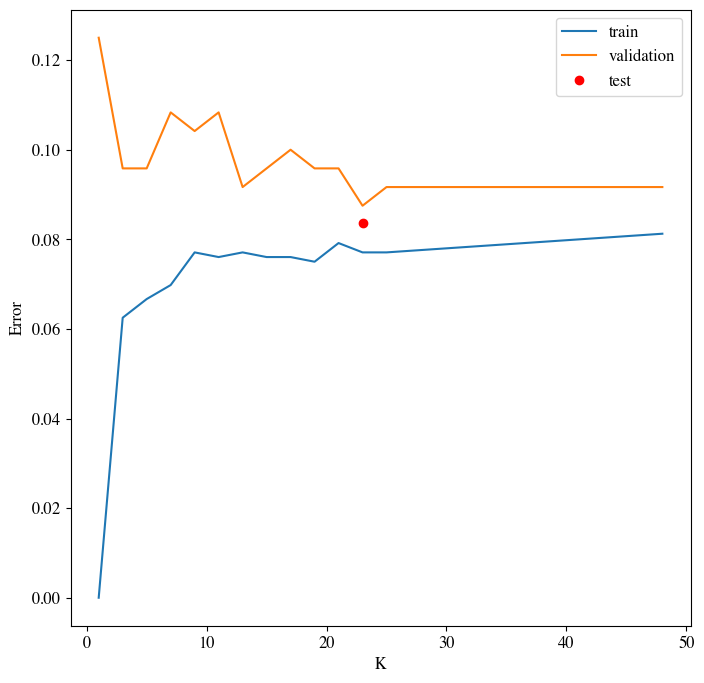

In [113]:
########## Plotting the trends ###########
# Plot training and validation accuracy in function of $k$
plt.figure(figsize=(8, 8))
_ = plt.plot(Krange, 1-accuracies)
_ = plt.plot(Krange, 1-accuracies_valid)
########### Selection on Validation ###########
# Select best K on validation and then testing with best K
accuracies_valid, accuracies
idx_best = np.argmax(accuracies_valid)
K_best_valid = Krange[idx_best]
############## Testing part ####################
# retrain with k_best and test
clf = KNeighborsClassifier(K_best_valid)
clf.fit(X_train_entire, y_train_entire)  # train on training with Kbest
score_test = clf.score(X_test, y_test)  # only now testing
_ = plt.plot(K_best_valid, 1-score_test, 'ro')
_ = plt.legend(['train', 'validation', 'test'])
_ = plt.xlabel('K')
_ = plt.ylabel('Error')

# Remember to estimate scaling on the training set only!

- In theory this is part below is an error.
- I took the code from sklearn documentation but in practice you have to estimate the scale parameters **ONLY** in the training set.
- Then applying it directly to the test set. 
- If you work in inductive settings, you cannot do it jointly like the code above.

```python
    ######### Watch out here ################
    X = StandardScaler().fit_transform(X) # in theory this is an error!
    # you want to estimate the scaling of data on the training set and 
    # then apply to valid and test
    #########################################
```

# Why showing training erros vs number of $k$?

## $k$-NN, leassons learned
- We also showed how $k$-NN overfits with $k=1$ and studied smoothing regularization effect.
- We also found a way to **measure the cost function** for $k$-NN, though there is no explicit learning.

## Towards Decision Trees
- The decision that $k$-NN takes when $k \gt 1$ is related with the concept of **impurity of a cluster** of datapoints
- This notion of **impurity** is key for understanding **Decision Trees**

# Impurity

- We will play a game and we will try to classify each of the upcoming data points with $k$-NN!

# Game
<center>
<img src="figs/impurity_00.png" width="50%"/>
</center>

# Ready?

<center>
<img src="figs/impurity_01.png" width="50%"/>
</center>

# Go!

<center>
<img src="figs/impurity_02.png" width="50%"/>
</center>




<center>
<img src="figs/impurity_03.png" width="50%"/>
</center>


<center>
<img src="figs/impurity_04.png" width="50%"/>
</center>


<center>
<img src="figs/impurity_05.png" width="50%"/>
</center>

<center>
<img src="figs/impurity_06.png" width="50%"/>
</center>

# 3 blues vs 3 reds $\rightarrow$ Tie! $\rightarrow$ high uncertainty!

<center>
<img src="figs/impurity_07.png" width="50%"/>
</center>

## How do we measure impurity?

# Impurity Functions

Data: $\mathcal{D}=\left \{ \left ( \mathbf{x}_1,y_1 \right ),\dots,\left ( \mathbf{x}_n,y_n \right ) \right \}, y_i\in\left \{ 1,\dots,K \right \}$, where $K$ is the number of classes

We will cover 3 impurity functions:

- Misclassification
- Gini Index
- Entropy

# Misclassification

# Misclassification

Let $S_k\subseteq S$ where $S_k=\left \{ \left ( \mathbf{x},y \right )\in S:y=k \right \}$ (all inputs restricted to have labels $k$)
<br>
$S=S_1\cup \dots \cup S_c$
<br><br>
<u>Define</u>: 

$$p_k=\frac{\left | S_k \right |}{\left | S \right |}\leftarrow \textrm{fraction of inputs in } S \textrm{ with label } k$$

$p_k$ is the probability of picking a point with label $k$, then the **Missclassification** is:

$$ H(S) = 1 - \max_k(p_{k}) $$

# What is the misclassification of this set?
<br>
- Just consider the colored points.
<center>
<img src="figs/impurity_06.png" width="50%"/>
</center>

<center>
<img src="figs/impurity_06.png" width="50%"/>
</center>

- We have 4 points in total.
- 3 reds and 1 blue
- $p_{\text{red}}=\frac{3}{4}$ vs $p_{\text{blue}} = \frac{1}{4}$

then Misclassification $ H(S) = 1 - \max(p_{k}) = 1-\max\{\frac{3}{4},\frac{1}{4}\} = \frac{1}{4} = 25\%$

# What about this
We have 3 classes now
<center>
<img src="figs/impurity_09.png" width="50%"/>
</center>

<center>
<img src="figs/impurity_09.png" width="50%"/>
</center>

- We still have 4 points in total.
- 2 reds and 1 blue and 1 green
- $p_{\text{red}}=\frac{2}{4}$ vs $p_{\text{blue}} = \frac{1}{4}$ vs $p_{\text{green}} = \frac{1}{4}$

then Misclassification $ H(S) = 1 - \max(p_{k}) = 1-\max\{\frac{2}{4},\frac{1}{4},\frac{1}{4}\}=50\%$

# Which one is better?

<center>
<img src="figs/impurity_08.png" width="50%"/>
</center>

# Which one is better?

<center>
<img src="figs/impurity_09.png" width="50%"/>
</center>

# The lower the misclassification, the better it is

# This works for all impurity metrics. 
## The lower they are, the better it is!
### It is similar to a cost/loss function

# Plot Miclassification function for binary case

```python
pk = np.arange(0, 1.1, 0.1)
missclassification_binary = 1 - np.maximum(pk, 1 - pk) #runs over K
_ = plt.plot(pk, missclassification_binary)
```

{{import numpy as np;pk = np.arange(0, 1.1, 0.1); missclassification_binary = 1-np.maximum(pk, 1-pk); _ = plt.plot(pk, missclassification_binary);_ = plt.xlabel('p');_ = plt.ylabel('Miclassification')}}

# Gini impurity

# Gini impurity

Let $S_k\subseteq S$ where $S_k=\left \{ \left ( \mathbf{x},y \right )\in S:y=k \right \}$ (all inputs restricted to have labels $k$)
<br>
$S=S_1\cup \dots \cup S_c$
<br><br>
<u>Define</u>: 

$$p_k=\frac{\left | S_k \right |}{\left | S \right |}\leftarrow \textrm{fraction of inputs in } S \textrm{ with label } k$$

$p_k$ is the probability of picking a point with label $k$, then the **Gini Impurity** is:

$$ G(S)=\sum_{k=1}^{K}p_k(1-p_k) $$

In words, we aggregate over classes and for each class $k$, we multiply:
- probabilty of picking $k$ aka $p_k$
- by its inverse aka $(1-p_k)$.

# Gini impurity

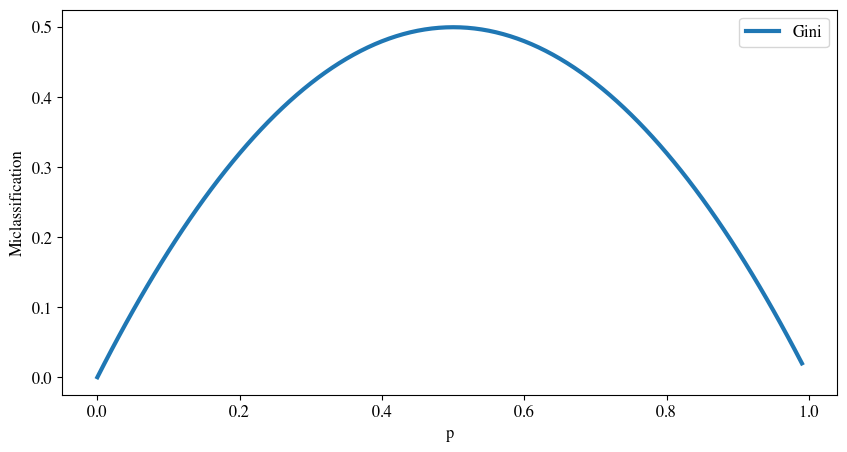

In [114]:
%matplotlib inline
import numpy as np
pk = np.arange(1e-9, 1.0, 1e-2)
missclassification_binary = 1-np.maximum(pk, 1-pk)
kwargs = {'linewidth': 3}
plt.figure(figsize=(10, 5))
_ = plt.plot(pk, 2*pk*(1-pk), **kwargs)
_ = plt.xlabel('p')
_ = plt.ylabel('Miclassification')
_ = plt.legend(['Gini'])

# Entropy

# Entropy: Intuition

In which of the two series there is more __confusion__?

#### Sequence A

|0|0|0|1|0|0|0|0|0|0|0|0|0|0|0|1|0|0|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|

#### Sequence B

|0|1|0|1|0|0|1|0|0|1|1|0|0|0|0|1|0|1|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|


#### Sequence A

|0|0|0|1|0|0|0|0|0|0|0|0|0|0|0|1|0|0|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|

{{ import matplotlib; import matplotlib.pyplot as plt;seqA = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]; _=plt.bar(*np.unique(seqA, return_counts=True));}}

```python
plt.hist(seqA, bins=2, density=True) # OR
plt.bar(*np.unique(seqB, return_counts=True))
```

#### Sequence B

|0|1|0|1|0|0|1|0|0|1|1|0|0|0|0|1|0|1|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|


{{ seqB = [0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1]; _=plt.bar(*np.unique(seqB, return_counts=True));}}

```python
plt.hist(seqA, bins=2, density=True) # OR
plt.bar(*np.unique(seqB, return_counts=True))
```

# Entropy of A is lower than Entropy of B
**A**
<div align='center'>
<img width="30%" src="figs/ent_a.png" />
<div/>
    
**B** 
    
<div align='center'>
<img width="30%" src="figs/ent_b.png" />
<div/>

# Definition of Entropy 

If $X$ is a discrete random variable that can take values $\{x_1,\ldots,x_n\}$ with probability $\{p(x_1),\ldots,p(x_n)\}$ then:

$$
H(X) \doteq -\sum_{x \in X} p(x)\log_2 p(x)
$$

- How surprised are we by a new value in the sequence?
- How much information does it convey?

# Entropy

> Let's say that you have a **unfair dice** that always return **`6`**. How would you be exicted to play a game with your friend using this dice?

<center>
<img src="figs/dice.png" width="30%"/>
</center>


# No excitment! I always know the answer beforehand!

## Where the $\log()$ is coming from?

- We considering a discrete random variable $X$ and we ask how much information is received when we observe a specific value for this variable.
- Entropy tells the **"degree of surprise"**, so it must be related to probabily of event $X=x$

- $p(x) = 1$ we want $h(x) = 0 \rightarrow$    **[Boring] NO surprise, a very common event happens**
- $p(x) \rightarrow 0$ then $h(x)=\infty \rightarrow$  **[Excitment] Lots of surprise, a rare event happens**

- We also want that if two events are **independent** $p(x,y) = p(x)p(y)$
- we want $h(x,y) = h(x) + h(y)$ **we sum the surprises** 

$$ \log\big(p(x)p(y)\big) = \underbrace{\log\big(p(x)\big)}_{h(x)}+\underbrace{\log\big(p(y)\big)}_{h(y)} $$

### A good choice is $-\log()$: it satisfies all the above properties

- You can think of $-\log(\mathbf{x})$ or else $\log(1/\mathbf{x})$
- We want the "inverse" of the probability and then $\log()$
```python
pk = np.arange(0.1, 1.1, 0.1)
_ = plt.plot(pk, -np.log(pk))
```

{{import numpy as np;pk = np.arange(0.1, 1.1, 0.1); _ = plt.plot(pk, -np.log(pk));_ = plt.xlabel('px');_ = plt.ylabel('-log(px)')}}

# Back to Entropy

Now suppose that a sender wishes to transmit the value of a random variable $X$ to a receiver. 

The average amount of information that they transmit in the process is obtained by taking the **expectation with respect to the distribution p(x) and is given by:**

$$
H(X) \doteq E[h(x)] = \sum_{x \in X} p(x)~h(x)=  -\sum_{x \in X} p(x)\log_2 p(x)
$$

> We can take advantage of the nonuniform distribution by using shorter codes for the more probable events, at the expense of longer codes for the less probable events, in the hope of getting a shorter average code length

# Measuring the "divergence" between two [discrete] distributions


**Objective**: Estimate a sort of "distance" (or better **divergence**) between two distributions **$p(x)$ vs $q(x)$**.

- We have an **unknown distribution** $p(x)$, 
- We want to model it using an **approximating distribution** $q(x)$. 

If we use $q(x)$ to construct a coding scheme for the purpose of transmitting values of $x$ to a receiver instead of $p(x)$, then the **average additional amount of information** required to specify the value of $x$ as a result of using $q(x)$ instead of the true distribution $p(x)$ is given by:

$$ 
\underbrace{H(P,Q)}_{\text{q not p, so extra}} - \underbrace{~~H(P)~~}_{\text{best we can do}}
$$

**Idea**: if you use **q** instead of **p**, but the underlying process is governed by **p**, then you need to pay an extra price in transmittion a bit more of information. "The bit more" is the equation above.

# Measuring the "divergence" between two distributions

$$ 
H(P,Q) - H(P) = \underbrace{-\sum_{x \in X} p(x)\log q(x)}_{\text{cross-entropy}} - \underbrace{\big(-\sum_{x \in X} p(x)\log p(x)\big)}_{\text{entropy}}
$$

# Measuring the "divergence" between two distributions

$$ 
H(P,Q) - H(P) = \underbrace{-\sum_{x \in X} p(x)\log q(x)}_{\text{cross-entropy}} - \underbrace{\big(-\sum_{x \in X} p(x)\log p(x)\big)}_{\text{entropy}}=
$$

$$ 
= -\sum_{x \in X} p(x)\log \Big( \frac{q(x)}{p(x)} \Big) =  \sum_{x \in X} p(x)\log \Big( \frac{p(x)}{q(x)} \Big) 
$$

# Relative entropy or Kullback-Leibler (KL) divergence

$$ 
KL(P||Q)= \sum_{x \in X} p(x)\log \Big( \frac{p(x)}{q(x)} \Big)
$$

**Note that:**

- $KL(P||Q) \neq KL(Q||P)$ so it is **NOT a distance metric**, but thankfully the following holds:
- $KL(P||Q) = 0 \longleftrightarrow p = q$

# Learning a decision tree is about <ins>reducing impurity</ins>

- So we want to reduce 1) Misclassification or 2)Gini Impurity or 3) **? What else ?**

- **Know your enemy**: the uniform distributions $\mbf{x} \sim\mathcal{U}$
- If we have $K$ classes then $\{q_1,\ldots, q_k\} = \{1/K,\ldots, 1/K\}$

We want find a function $f(p)$ so that $f(p)$ is very distant from uniform distribution $Q$, so we can use KL divergence for this:

$$
KL(P||Q)= \sum_{k=1}^K p(x)\log \Big( \frac{p(x)}{1/K} \Big) = \sum_{k=1}^K p(x)\log\big(p(x)\big)-p(x)\log\big(1/K\big)
$$

$$
KL(P||Q)= \sum_{k=1}^K p(x)\log \Big( \frac{p(x)}{1/K} \Big) = \sum_{k=1}^K p(x)\log\big(p(x)\big)-p(x)\log\big(1/K\big) = \sum_{k=1}^K p(x)\log\big(p(x)\big)+p(x)\log\big(K\big)
$$

$$
\sum_{k=1}^K p(x)\log\big(p(x)\big)+ \sum_{k=1}^K p(x)\log\big(K\big) =  \sum_{k=1}^K p(x)\log\big(p(x)\big)+ \log\big(K\big)\underbrace{\sum_{k=1}^K p(x)}_{1}
$$

$$
KL(P||Q)=  \sum_{k=1}^K p(x)\log\big(p(x)\big)+\text{const.}
$$

We want to be far away from Q so let's maximize the divergence:

$$
\max_P \sum_{k=1}^K p(x)\log\big(p(x)\big) \rightarrow \min_P -\sum_{k=1}^K p(x)\log\big(p(x)\big)
$$

So this tell us find the **$P$** so that we minimize the Entropy:
$$
\min_P \underbrace{-\sum_{k=1}^K p(x)\log\big(p(x)\big)}_{\text{entropy}} = \min_P H(P).
$$

Which is equivalent of saying: **in order to find a good tree, you should minimize the entropy!**

# Artificial Intelligence and Machine Learning

## Unit II


## Decision Trees and Random Forest

# Today's lecture
## Another "non-parametric" model
### Decision Trees and Random Forest


# This lecture material is taken from
- Information Theory part  - (Entropy etc) is taken from __Chapter 1 - Bishop__.
- Decision Trees are very briefly covered in __Bishop at page 663__.
- [Cimi Book - Chapter 01](http://ciml.info/dl/v0_99/ciml-v0_99-ch01.pdf)
- [CSC411: Introduction to Machine Learning](https://www.cs.toronto.edu/~urtasun/courses/CSC411_Fall16/06_trees_handout.pdf)
- [CSC411: Introduction to Machine Learning - Tutorial](https://www.cs.toronto.edu/~urtasun/courses/CSC411_Fall16/tutorial3.pdf)
- [Cornell ML course](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote17.html)
- [Cornell ML course Bagging](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote18.html)

# Motivation for Entropy

- Maximing the divergence of your tree from the unifrom distribution _[of the classes]_ boils down to **maximize the KL divergence between a distribution P and Uniform on the classes**.
- Maximing KL wrt to Uniform  $\rightarrow$ **minimize the entropy of data class-label.**

# Impurity functions review



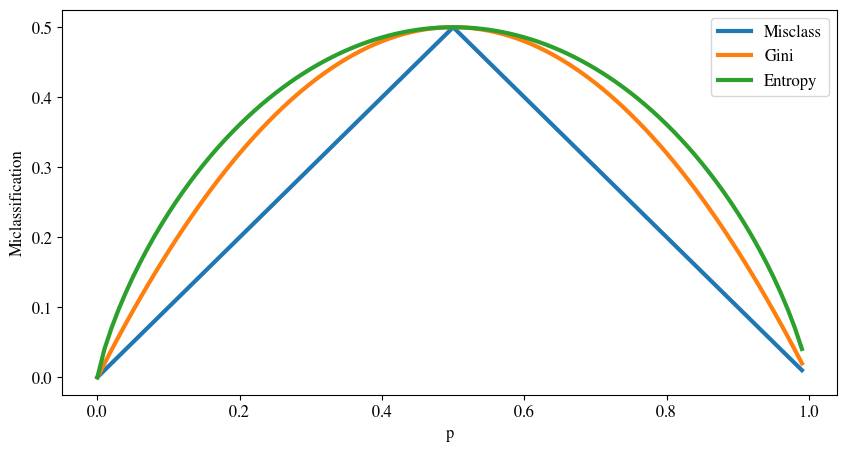

In [115]:
import numpy as np
pk = np.arange(1e-9, 1.0, 1e-2)
missclassification_binary = 1-np.maximum(pk, 1-pk)
kwargs = {'linewidth': 3}
plt.figure(figsize=(10, 5))
_ = plt.plot(pk, missclassification_binary, **kwargs)
_ = plt.plot(pk, 2*pk*(1-pk), **kwargs)
_ = plt.plot(pk, -1/2*pk*np.log2(pk)-1/2*(1-pk)*np.log2(1-pk), **kwargs)
_ = plt.xlabel('p')
_ = plt.ylabel('Miclassification')
_ = plt.legend(['Misclass', 'Gini', 'Entropy'])

# From Impurity of a Set to Impurity of a Tree

# Impurity of a Tree with a recursive definition:

$$H(\texttt{Tree};S)=\frac{\left | S_L \right |}{\left | S \right |}H(S_L)+\frac{\left | S_R \right |}{\left | S \right |}H(S_R)$$

where:

<ul>
<li> $\left ( S=S_L\cup S_R \right )$</li>
<li> $S_L\cap S_R=\varnothing$</li>
<li> $\frac{\left | S_L \right |}{\left | S \right |}\leftarrow \textrm{fraction of inputs in left subtree}$</li>
<li> $\frac{\left | S_R \right |}{\left | S \right |}\leftarrow \textrm{fraction of inputs in right subtree}$</li>
</ul>

Note: you can replace $H$ with ones of the Impurty function we have seen.

# Why Misclassification is a bad loss function

- Different splitting results give the same loss value if we use classification loss type. 
- New split regions do not reduce the original loss.
- The misclassifcation loss shape is **not concave** (here for a binary classification problem)

<div align='center'>
<img width="50%" src="figs/missclass_split.png" />
<div/>

<div align='center'>
<img width="50%" src="figs/missclass_split2.png" />
<div/>

# Misclassification is a bad impurity function

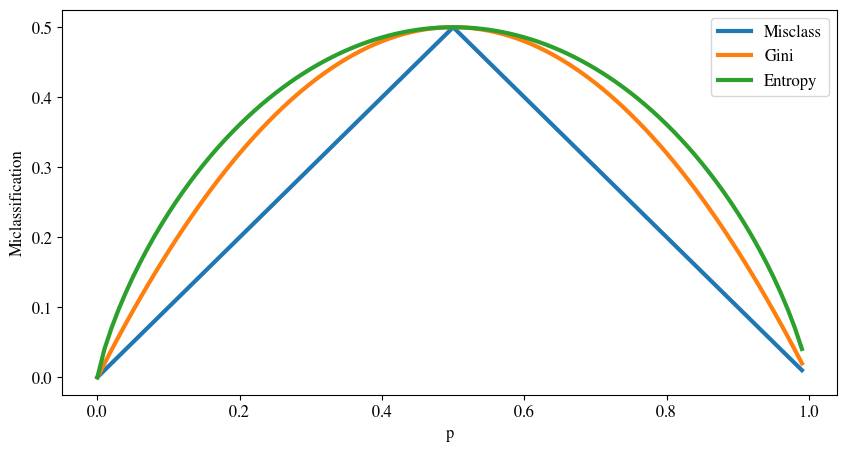

In [116]:
import numpy as np
pk = np.arange(1e-9, 1.0, 1e-2)
missclassification_binary = 1-np.maximum(pk, 1-pk)
kwargs = {'linewidth': 3}
plt.figure(figsize=(10, 5))
_ = plt.plot(pk, missclassification_binary, **kwargs)
_ = plt.plot(pk, 2*pk*(1-pk), **kwargs)
_ = plt.plot(pk, -1/2*pk*np.log2(pk)-1/2*(1-pk)*np.log2(1-pk), **kwargs)
_ = plt.xlabel('p')
_ = plt.ylabel('Miclassification')
_ = plt.legend(['Misclass', 'Gini', 'Entropy'])

# Learning a Decision Tree

# Learning a Decision Tree

- Learning the simplest (smallest) decision tree is an **NP complete problem** _[Hyafil & Rivest 1976]_
- Like in K-means we proceed with a **greedy approach** by minimizing the entropy of the entire tree $\min_P H(P)$

# Learning a Decision Tree: 
## Simple, greedy, recursive approach, builds up tree node-by-node

- Resort to a **greedy heuristic**:
    1. Start from an empty decision tree
    2. **[Greedy Step]** Choose _A) a dimension among axes B) **BEST** splitting value that minimize the Impurity function on the chosen axes_
        - When Impurity is Entropy we **minimize the entropy** also know as **maximizing the Information Gain**
    3. Once A) and B) are chosen save them as "parameters" of the model
    4. Apply **recursion to the sub-problem**.


# Learning a Decision Tree: 
## Simple, greedy, recursive approach, builds up tree node-by-node

    
- **Termination**:
    1. if no examples – return **majority** from parent (Voting such as in k-NN).
    2. else if all examples in same class – return the class **(pure node)**.
    3. else we are not in a termination node (keep recursing)
    4. **[Optional]** we could also terminate for some **regularization** parameters

# Information Gain

- To minimize the entropy, we practically maximize the information gain, given **we chose an attribute**.
- We pick the maximum over information gain

$$IG(Y|X) = \underbrace{H(Y)}_{\text{prior entropy in the node}} - \underbrace{H(Y|X)}_{\text{new, conditioned on the split}} \qquad \forall~X~~\text{splitting attribute}$$

# Learning a Decision Tree for Classification: Toy Sample


<img width="40%" src="figs/data_01.png?2" />

[Taken from wei2624.github.io](https://wei2624.github.io/MachineLearning/sv_trees/)

## Which axis and value do we split?

# Learning a Decision Tree for Classification: Toy Sample

<div align='center'>
<img width="40%" src="figs/data_02.png" />
<div/>

# The current decision tree

<div align='center'>
<img width="40%" src="figs/data_03.png" />
<div/>

<div align='center'>
<img width="40%" src="figs/data_02.png" />
<img width="30%" src="figs/split_00.png?1" />
<div/>

# Region 1 on the left is pure so we are done on $R_1$

<div align='center'>
<img width="40%" src="figs/data_02.png" />
<div/>

# Let's split $R_2$

# Region 1 on the left is pure so we are done on $R_1$

<div align='center'>
<img width="35%" src="figs/data_02.png" />
<div/>
    
# First try all values on horizontal axes for $R_2$ (right)

<div align='center'>
<img width="40%" src="figs/data_02.png" />
<img width="30%" src="figs/split_00.png" />
<div/>

# Now let's try all values on vertical axes for $R_2$ (right)

<div align='center'>
<img width="35%" src="figs/data_01.png" />
<img width="30%" src="figs/split_01.png" />
<div/>

# Much better gain in split on vertical axes  at value $\approx 2.7$
<div align='center'>
<img width="40%" src="figs/data_04.png?2" />
</div>

# The Final Decision Tree

<img width="40%" src="figs/tree_02.png?2" />

# Test point to classify?

<div align='center'>
<img width="80%" src="figs/data_04.png" />
<div/>

# The Final Decision Tree

<div align='center'>
<img width="80%" src="figs/tree_02.png" />
<div/>

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors, datasets
# import some data to play with
iris = datasets.load_iris()
# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2] # Nx2 
y = iris.target      # Nx1

# The data

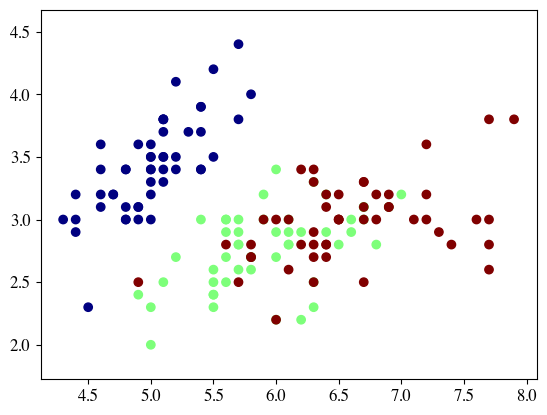

In [118]:
plt.scatter(*X.T, c=y, cmap='jet');
plt.axis('equal');

In [119]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=1)
clf = clf.fit(X, y)

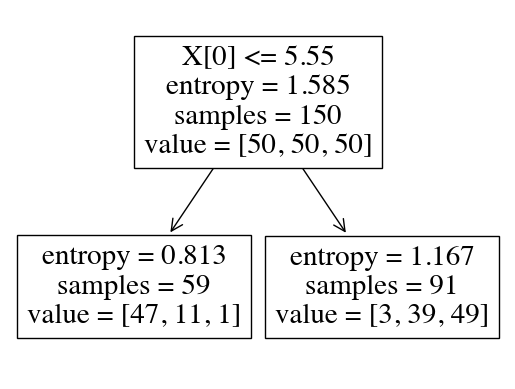

In [120]:
tree.plot_tree(clf);

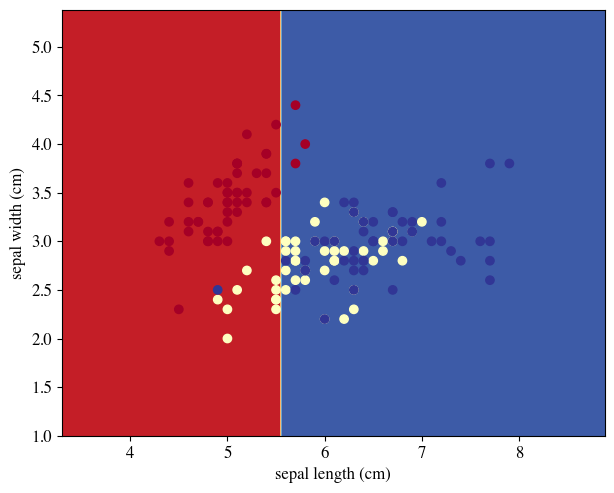

In [121]:
# Parameters #########
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02
######################

plt.figure(figsize=(7,7))
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

# Plot the training points
plt.scatter(*X.T, c=y, cmap=plt.cm.RdYlBu);
# for i, color in zip(range(n_classes), plot_colors):
#     idx = np.where(y == i)
#     plt.scatter(
#         X[idx, 0],
#         X[idx, 1],
#         label=iris.target_names[i],
#         cmap=plt.cm.RdYlBu,
#         edgecolor="black",
#         s=50,
#     )

plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
plt.axis('scaled');
plt.axis('on');

In [122]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=2)
clf = clf.fit(X, y)

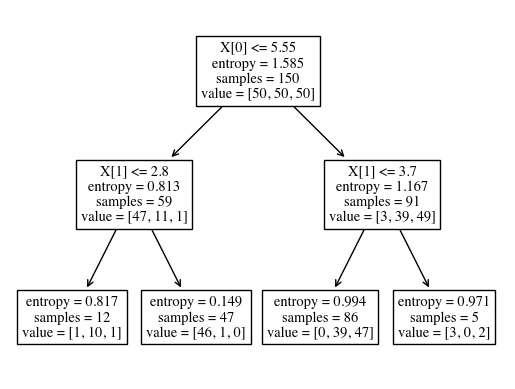

In [123]:
tree.plot_tree(clf);

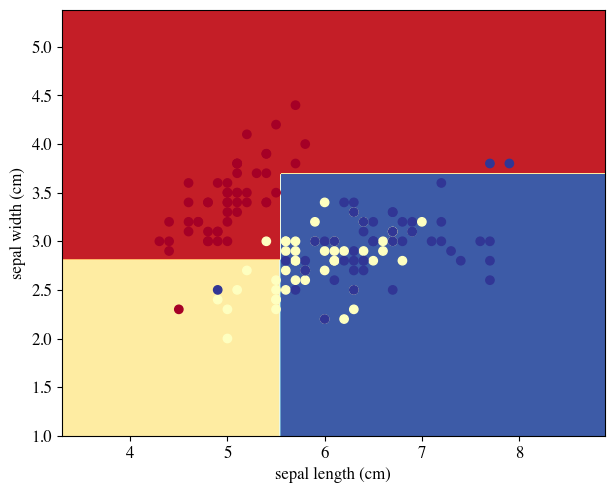

In [124]:
# Parameters #########
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02
######################

plt.figure(figsize=(7,7))
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

# Plot the training points
plt.scatter(*X.T, c=y, cmap=plt.cm.RdYlBu);
# for i, color in zip(range(n_classes), plot_colors):
#     idx = np.where(y == i)
#     plt.scatter(
#         X[idx, 0],
#         X[idx, 1],
#         c=color,
#         label=iris.target_names[i],
#         cmap=plt.cm.RdYlBu,
#         edgecolor="black",
#         s=50,
#     )

plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
plt.axis('scaled');
plt.axis('on');

In [125]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=3)
clf = clf.fit(X, y)

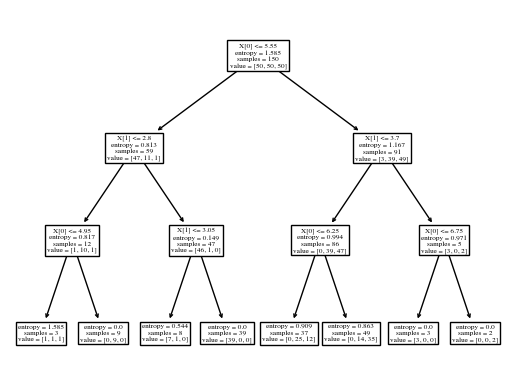

In [126]:
tree.plot_tree(clf);

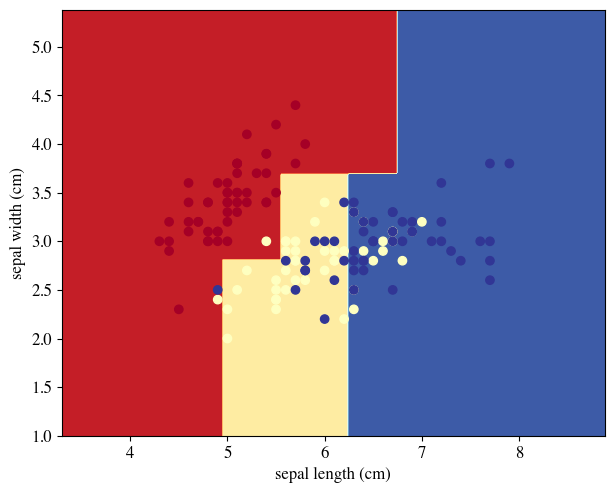

In [127]:
# Parameters #########
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02
######################

plt.figure(figsize=(7,7))
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

# Plot the training points
plt.scatter(*X.T, c=y, cmap=plt.cm.RdYlBu);
# for i, color in zip(range(n_classes), plot_colors):
#     idx = np.where(y == i)
#     plt.scatter(
#         X[idx, 0],
#         X[idx, 1],
#         c=color,
#         label=iris.target_names[i],
#         cmap=plt.cm.RdYlBu,
#         edgecolor="black",
#         s=50,
#     )

plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
plt.axis('scaled');
plt.axis('on');

In [128]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=4)
clf = clf.fit(X, y)

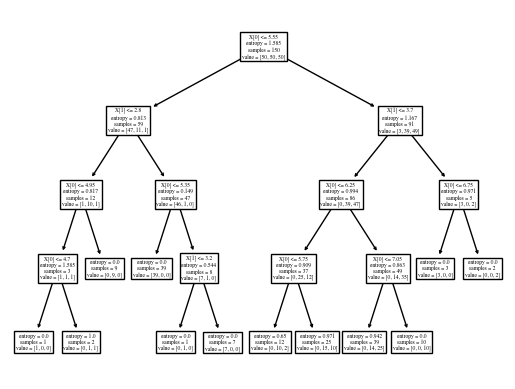

In [129]:
tree.plot_tree(clf);

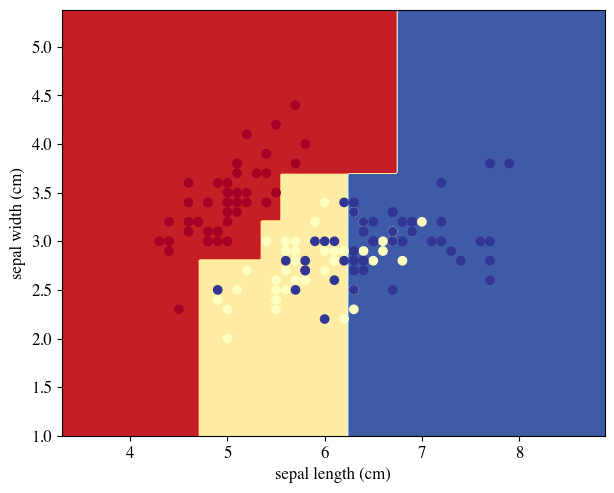

In [130]:
# Parameters #########
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02
######################

plt.figure(figsize=(7,7))
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

# Plot the training points
plt.scatter(*X.T, c=y, cmap=plt.cm.RdYlBu);
# for i, color in zip(range(n_classes), plot_colors):
#     idx = np.where(y == i)
#     plt.scatter(
#         X[idx, 0],
#         X[idx, 1],
#         c=color,
#         label=iris.target_names[i],
#         cmap=plt.cm.RdYlBu,
#         edgecolor="black",
#         s=50,
#     )

plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
plt.axis('scaled');
plt.axis('on');

# Let's try our "problematic" dataset (for PCA and k-NN)

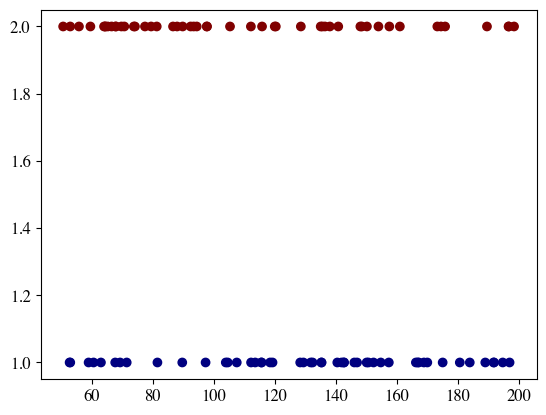

In [131]:
np.random.seed(0)
N_samples = 50
# samples points for class 1
X_1 = np.random.uniform(50, 200, N_samples)
X_1 = np.vstack((X_1, (1,)*N_samples))
# samples points for class 2
X_2 = np.random.uniform(50, 200, N_samples)
X_2 = np.vstack((X_2, (2,)*N_samples))
X = np.concatenate((X_1, X_2))
# data
X = np.concatenate((X_1, X_2), axis=1)
# labels
labels = X[1, ...]
# Plot also the training points
plt.scatter(
    x=X[0, ...],
    y=X[1, ...],
    c=labels,
    cmap='jet',
)
# Code below wants Nx2
X = X.T

In [132]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=2)
clf = clf.fit(X, labels)

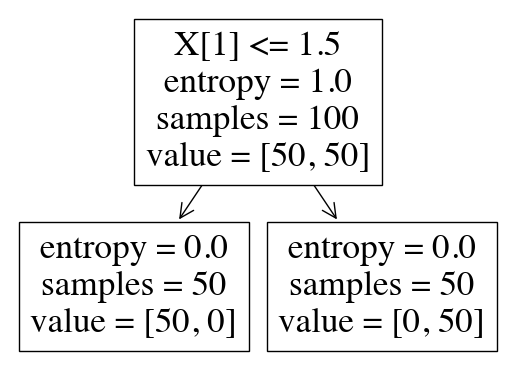

In [133]:
tree.plot_tree(clf);

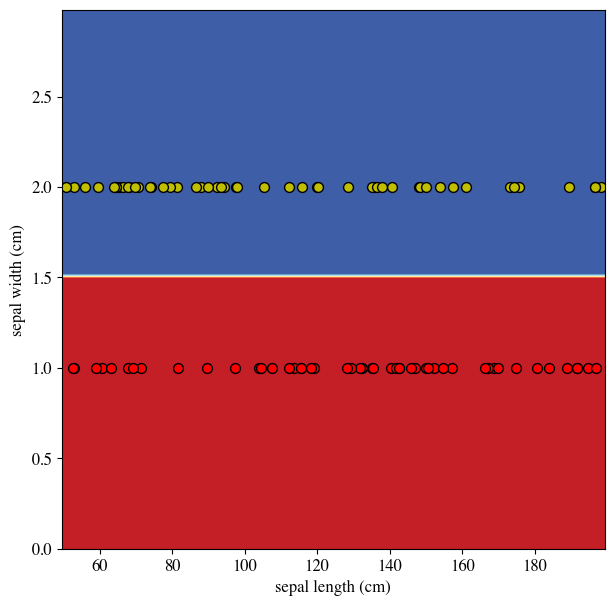

In [134]:
# Parameters #########
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02
######################

plt.figure(figsize=(7,7))
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

# Plot the training points
for i, color in zip(range(2), plot_colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0],
        X[idx, 1],
        c=color,
        label=labels,
        #cmap=plt.cm.RdYlBu,
        edgecolor="black",
        s=50,
    )

plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
#plt.axis('scaled');
plt.axis('on');

# Pro: Decision trees do not need feature preprocessing!

# Con: Decision Trees are very prone to overfit 

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors, datasets
# import some data to play with
iris = datasets.load_iris()
# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2] # Nx2 
y = iris.target      # Nx1

# The data

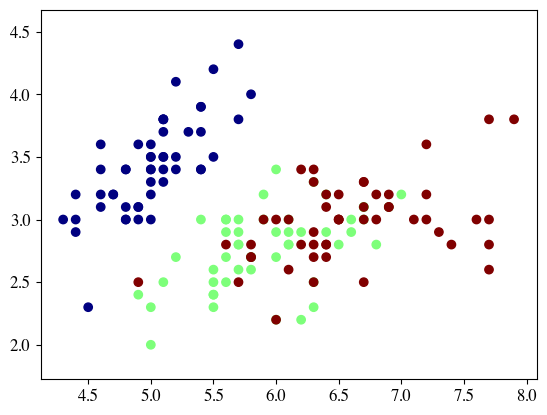

In [136]:
plt.scatter(*X.T, c=y, cmap='jet');
plt.axis('equal');

In [137]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='best')
clf = clf.fit(X, y)

In [ ]:
tree.plot_tree(clf);

In [ ]:
# Parameters #########
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02
######################

plt.figure(figsize=(7,7))
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)


score = clf.score(X, y)
# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0],
        X[idx, 1],
        c=color,
        label=y,
        #cmap=plt.cm.RdYlBu,
        edgecolor="black",
        s=50,
    )
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
#plt.axis('scaled');
plt.axis('on');

# Decision Tree Setup

```python
        #########################################
        clf = tree.DecisionTreeClassifier(
            criterion='entropy', 
            splitter='best',
            max_depth=depth,
            max_features=None,
            min_impurity_decrease=0.001)
       ################################
```

### **min_impurity_decrease : float, default=0.0**

A node will be split if this split induces a decrease of the impurity
greater than or equal to this value.

The weighted impurity decrease equation is the following:
```
    N_t / N * (impurity - N_t_R / N_t * right_impurity
                                - N_t_L / N_t * left_impurity)
```
where:
- ``N`` is the total number of samples
- ``N_t`` is the number of samples at the current node, 
- ``N_t_L`` is the number of samples in the
left child, and 
- ``N_t_R`` is the number of samples in the right child.

In [ ]:
%matplotlib inline
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
###################
h = 0.02  # step size in the mesh
plot_train_points = True
idx_plot = 1  # plot points of attempt idx_plot
#################

names = [
    "DT",
]

Krange = list(range(1, 27))
accuracies = np.zeros_like(Krange, dtype=np.float32)
accuracies_valid = np.zeros_like(Krange, dtype=np.float32)

datasets = [
    make_moons(n_samples=2000, noise=0.3, random_state=0),
]

figure = plt.figure(figsize=(20, 20))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(Krange) + 1, 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    #i += 1
    # iterate over classifiers
    mid = len(Krange)//2
    for depth in Krange:
        #########################################
        clf = tree.DecisionTreeClassifier(
            criterion='entropy', 
            splitter='best',
            max_depth=depth,
            max_features=None,
            min_impurity_decrease=0.001)
       ################################
        ax = plt.subplot(mid, mid, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_train, y_train)
        score_test = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot the training points
        if i == idx_plot and plot_train_points:
            ax.scatter(
                X_train[:, 0], X_train[:, 1],
                c=y_train[:], cmap=cm_bright,  alpha=0.6, s=2
            )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(names[0]+f' Depth={depth}')
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        # recording the accuracies
        accuracies[i-1] = score
        accuracies_valid[i-1] = score_test
        # print(accuracies,i,score)
        i += 1

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
_ = plt.plot(Krange, 1 - accuracies, 'o--')
_ = plt.plot(Krange, 1 - accuracies_valid, 'o--')
_ = plt.title('Decision Trees Training/Valid Error')
plt.legend(['Train','Valid'])
_ = plt.xlabel('Depth')

# Wrap-up for classification

Given training vectors $\{\mbf{x}_i, y_i\}$ a decision tree recursively partitions the feature space such that the samples with the same labels are grouped
together **(decrease impurity)**

Let the data at node $m$ be represented by $Q_m$ with $N_m$
samples. 

For each candidate split $\boldsymbol{\theta} = (j, t_m)$ consisting of a
**feature $j$** and **threshold $t_m$**, partition the data into
$Q_m^{L}(\theta)$ and $Q_m^{R}(\theta)$ subsets

$$Q_m^{L}(\theta) = \{(x, y) | x_j \le t_m\} \\ Q_m^{R}(\theta) = Q_m \setminus Q_m^{L}(\theta)
$$

The set of all splits $\{\boldsymbol{\theta}_m = (j, t_m)\}_{m=1}^M$ can be interpreted as the "parameters" of the model.

[From sklean](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation)

# Decision Tree at a glance
The **quality of a candidate** split of node $m$ is then computed using an
**impurity function or loss function $H()$**.

$$G(Q, \theta) = \frac{N^{L}}{N} H(Q^{L}(\theta))   + \frac{N^{R}}{N} H(Q^{R}(\theta))
$$
Select the parameters that minimises the impurity

$$
\boldsymbol{\theta}^* = \operatorname{argmin}_\boldsymbol{\theta}  G(Q_m, \theta)
$$

# Decision tree for regression

The idea is the same but changes the loss function from **impurity** to $\ell_2^2$(MSE - Mean Square Error) or $\ell_1$ (Mean Absolute Error)

$$\bar{y}_m = \frac{1}{N_m} \sum_{y \in Q_m} y$$

$$H(Q_m) = \frac{1}{N_m} \sum_{y \in Q_m} (y - \bar{y}_m)^2$$

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=1)
regr_2 = DecisionTreeRegressor(max_depth=2)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure(figsize=(14,10))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=1", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=2", linewidth=2)
plt.xlabel("Data $x$")
plt.ylabel("Target $y$")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

# Decision Regression Trees

Approximate the underlying function as a **piecewise constant function with discontinuities (non-smooth).**

In [ ]:
tree.plot_tree(regr_1);

In [ ]:
tree.plot_tree(regr_2);

# Remedies to Decision Trees Overfit and Intro to Random Forest

# What makes a good tree

- **Not too small (deep):** need to handle important but possibly subtle distinctions in data

- **Not too big:**
    - Computational efficiency (avoid redundant, spurious attributes)
    - Avoid over-fitting training examples

- **Occam’s Razor:** find the simplest hypothesis (smallest tree) that fits the observations
- **Inductive bias:** small trees with informative nodes near the root

# Quick Remedies


1. **Minimum Leaf Size:** We can setup a minimum number of leaf "size". The minimum number of samples required to be at a leaf node. 

2. **Maximum Depth:** We can also set the threshold value on the tree depth.

3. **Relative Impurity Decrease:** A node will be split if this split induces a decrease of the impurity greater than or equal to this value.


```python
class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', 
splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1,
min_weight_fraction_leaf=0.0, max_features=None, 
random_state=None, max_leaf_nodes=None, 
min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)
```

# Quick Remedies

However, even if we have these **on-hand weapon to avoid overfitting**, it is **still hard to train a single decision tree to perform well generally**. Thus, we will use another useful training technique called **ensemble methods or bagging**, which leads to random-forest.

# Brief Intro to Random Forest

Random Forest are an application of **Ensemble Methods** or **Bagging.**

_[Tibshirani book, pag. 587]_

## Ensemble Methods (Bagging)

- Motivation: solve the **variance problem** (you fit too much the data)
- Train different classifiers $h(\cdot)_{\mbf{D}_j}$ on **$M$ different datsets** $\{\mbf{D}_1,\ldots,\mbf{D}_m\}$ still sampled from the same generative process $
 \underbrace{\{\bx_i,y_i\}_{i=1}^N}_{\text{known}} \sim \underbrace{\mathcal{\mathcal{D}}}_{\text{unknown}}
$
- Average the results of different classifiers:
$$
h(\mbf{x}) = \frac{1}{M}\sum_{j=1}^M h(\mbf{x})_{\mbf{D}_j}
$$

# How to create the ensemble

<br>
<div align='center'>
<img width="80%" src="figs/ensemble.png" />
<div/>

# Random Forest

- **Bagging** applied to **Decision Trees**
- Each tree is very specific to a dataset $\mbf{D}_j$
- When splitting, each tree looks at <ins>most $K$ features randomly</ins> from the $D$ we have ($\mbf{x}\in \mathbb{R}^D$)
- It follows that we do NOT split on all axis and $K \ll D$ and $K=\sqrt{D}$.
- **Idea:** Inject noise in each tree so they will make different errors for each $\mbf{D}_j$ so that at the end each error "clears out when averaging."



In [ ]:
###################
from sklearn.ensemble import RandomForestClassifier
h = 0.02  # step size in the mesh
plot_train_points = True
idx_plot = 1  # plot points of attempt idx_plot
#################
names = [
    "RF",
]

Krange = list(range(1, 27))

accuracies_rf = np.zeros_like(Krange, dtype=np.float32)
accuracies_valid_rf = np.zeros_like(Krange, dtype=np.float32)

datasets = [
    make_moons(n_samples=2000, noise=0.3, random_state=0),
]

figure = plt.figure(figsize=(20, 20))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(Krange) + 1, 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    #i += 1
    # iterate over classifiers
    mid = len(Krange)//2
    for depth in Krange:
        #######################
        clf = RandomForestClassifier(
            criterion='entropy',
            n_estimators=100,
            max_depth=depth,
            min_impurity_decrease=0.001)
        ###################################
        
        ax = plt.subplot(mid, mid, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_train, y_train)
        score_test = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot the training points
        if i == idx_plot and plot_train_points:
            ax.scatter(
                X_train[:, 0], X_train[:, 1],
                c=y_train[:], cmap=cm_bright,  alpha=0.6, s=2
            )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(names[0]+f' Depth={depth}')
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        # recording the accuracies
        accuracies_rf[i-1] = score
        accuracies_valid_rf[i-1] = score_test
        # print(accuracies,i,score)
        i += 1

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
_ = plt.plot(Krange, 1 - accuracies, 'o--')
_ = plt.plot(Krange, 1 - accuracies_valid, 'o--')
_ = plt.plot(Krange, 1 - accuracies_rf, 'x--')
_ = plt.plot(Krange, 1 - accuracies_valid_rf, 'x--')
_ = plt.title('Decision Trees Training/Valid Error')
plt.legend(['Train (DT)','Valid (DT)','Train (RF)','Valid (RF)'])
_ = plt.xlabel('Depth')

# Advantages of Random Forest

- Bagging remove hyper-param related to Depth of the Tree.
- $K=\sqrt{D}$ so it is a fixed hyper-param.
- You have to tune $M$ but in general needs to be large.
- DT are **very interpretable**; DT/RF could be used for **feature selection**
    - To answer the question: __which feature contribute more to the label?__
- You can evaluate them **without a validation split** (Out of Bag Generalization - OOB)

# Feature Importance Evaluation and Interpretability

- The **relative rank (i.e. depth)** of a feature used as a decision node in a tree can be used to assess the relative importance of that feature with respect to the predictability of the target variable. 
- **Features used at the top of the tree contribute to the final prediction decision of a larger fraction** of the input samples. 
- The expected fraction of the samples they contribute to can thus be used as an estimate of the relative importance of the features. 

- In scikit-learn, the **1) fraction of samples a feature contributes** to is combined with the **2) decrease in impurity** from splitting them to create a normalized estimate of the predictive power of that feature.

**By averaging the estimates of predictive ability over several randomized trees one can reduce the variance of such an estimate and use it for feature selection. This is known as the mean decrease in impurity, or MDI.**


```python
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
```
<div align='center'>
<img width="40%" src="figs/mdi.png" />
<div/>

# Out-of-Bag (OOB) Evaluation

- Remove **the need of a validation set**
- It gives you a **quick way to estimate the number of ensembles**
- Quick good hint of how the forest **generalization error** could be (without doing K-fold cros-validation)

In [ ]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = make_classification(
    n_samples=500,
    n_features=25,
    n_clusters_per_class=1,
    n_informative=15,
    random_state=RANDOM_STATE,
)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    (
        "RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features="sqrt",
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(
            warm_start=True,
            max_features="log2",
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features=None",
        RandomForestClassifier(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 150

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))
        
plt.figure(figsize=(12,7))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = make_classification(
    n_samples=500,
    n_features=25,
    n_clusters_per_class=1,
    n_informative=15,
    random_state=RANDOM_STATE,
)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    (
        "RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features="sqrt",
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(
            warm_start=True,
            max_features="log2",
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features=None",
        RandomForestClassifier(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 150

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))
        
plt.figure(figsize=(12,7))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

# Application: Human Pose Prediction in Xbox Kinect

<center>
<img width="60%" src="figs/xbox4.png" />
<center/>


<center>
<img width="90%" src="figs/xbox3.png" />
<center/>

# Decision trees are in XBox: Classifying body parts
### Trained on Millions of synthetic images

<center>
<img width="60%" src="figs/xbox.png" />
<center/>


<center>
<img width="90%" src="figs/xbox2.png" />
<center/>

[Link to the Microsoft paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/BodyPartRecognition.pdf)

_To keep the training times down we employ a distributed implementation. Training 3 trees to depth 20 from 1 million images takes about a day on a 1000 core cluster._

# Microsoft Kinect Research Presentation


[Link to video at the right time](https://www.youtube.com/watch?v=QPYf6pXe_4Q&t=24m39s)


In [ ]:
from IPython.display import Audio,Image, YouTubeVideo
from datetime import timedelta
id='QPYf6pXe_4Q'
start=int(timedelta(hours=0, minutes=24, seconds=0).total_seconds())
YouTubeVideo(id=id,width=1280,height=1024,start=start)

# Advantages of Decision Trees

- The decision is **highly interpretable** (you can explain the decision to a doctor).
- Learn which **feature correlates better w/ $y$** 
- **Do not need pre-processing** of the data
- **Complex** decision boundary that adapt to data density
- **Axis-aligned yet complex/segmented** decision boundaries
- Inference is **fast**: test attribute and split

# Disadvantages of Decision Trees


- Suffer for **Variance problem** (overfit)
- Sensitive to the training set _(variance)_
- **Greedy approach** does not yield the global optimal tree